# Part1-Theory

### A)

**Convolutional Networks** use a regular grid for sampling input feature maps during the convolution operation. The sampling points are evenly distributed based on the filter size and stride, but **Deformable Convolutional Networks** use learned offsets to adjust the regular grid during the sampling process. The offsets are learned from the data, enabling the network to sample input features from locations that are more informative for the specific task.

![image.png](attachment:image.png)
(a) regular sampling grid (green points) of standard convolution. (b) deformed sampling locations (dark blue points) with augmented offsets (light blue arrows) in deformable convolution.

As you see Traditional convolutional layers use fixed filters, where each filter has a fixed receptive field, and the same transformation is applied to all spatial locations within that field. Deformable convolutional layers use deformable convolutional kernels, allowing the network to adaptively adjust the receptive field for each spatial location. See following example from the article:

![image.png](attachment:image.png)

## B)

**DCNs** perform adaptive geometric transformations in images by learning spatial offsets for each location in the input feature map. This adaptability allows DCNs to adjust their convolutional kernels dynamically based on the content of the input image.

## C)

As I mentioned in the previous part, in ConvNets, each convolutional filter has a fixed receptive field. These fixed filters are designed to capture specific spatial patterns, and they might not adapt well to variations in rotation, scale, or orientation.

## D)

The deformable convolutional layer generates spatial offsets for each location in the input feature map. These offsets represent how much each location in the feature map should be shifted or deformed to better align with the features in the input image. The offsets are obtained by applying a convolutional layer over the same input feature map as you see in following figure.

![image.png](attachment:image.png)

During training, both the convolutional kernels for generating the output features and the offsets are learned simultaneously via backpropagation.

# Part2-Practical

### Data Preparation

In [3]:
# load libraries
import cv2
import os
import torch
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split

#### Download Dataset and exrtract labels from Json file

In [ ]:
# !wget 'http://images.cocodataset.org/zips/val2017.zip'
# !unzip "/content/val2017.zip" -d "/content"
# !wget 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
# !unzip "/content/annotations_trainval2017.zip" -d "/content"


In [6]:
# Load COCO annotation file
with open('annotations/instances_val2017.json', 'r') as f:
    coco_data = json.load(f)

# Extract category information
categories = {category['id']: category['name'] for category in coco_data['categories']}
print(categories)
print('Number of Classes:',len(coco_data['categories']))

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

Categories is a dictionary where keys are category IDs, and values are category names.

In [8]:
# Create a mapping between image IDs and category IDs
image_category_mapping = {}
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']
    category_id = annotation['category_id']

    if image_id not in image_category_mapping:
        image_category_mapping[image_id] = []

    image_category_mapping[image_id].append(category_id)

print(image_category_mapping)
print('Total Number of images:',len(image_category_mapping))

{289343: [18, 1, 15, 2], 61471: [18, 44, 70], 472375: [18, 4, 47, 47], 520301: [18], 579321: [18, 1], 494869: [18, 1, 50, 51, 51, 44, 51, 51, 1], 554002: [18, 1, 1, 1, 1, 1, 1, 1, 31, 31, 1, 62, 1, 1], 78823: [18, 64, 3, 3, 3], 419974: [18, 44, 44, 62, 67, 67, 1, 64, 64, 64, 64, 48, 49, 49, 15, 44, 46, 64, 1, 47, 49, 49, 48, 64, 79], 404484: [18, 64, 72, 1, 88], 329219: [18, 1, 49, 47, 47, 48, 50, 50, 47, 47, 47, 47, 47, 47, 47, 81, 50, 47, 47, 47, 47], 68078: [18, 44, 70, 81], 170893: [18, 70], 65485: [18, 3], 498286: [18, 3, 8], 424162: [18, 2, 2, 2, 3, 3, 1, 1, 27, 1, 2, 8, 3], 61108: [18, 2, 3, 15, 15, 15, 3, 3, 3], 67213: [18, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1], 365207: [18, 3, 3, 15, 3], 131273: [18], 279278: [18, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 41, 47, 31, 31, 2, 1, 2, 2, 2, 2, 1, 2], 482100: [64, 64, 64, 70, 70, 64, 64], 540502: [64, 82, 51, 53, 53, 55, 78, 79, 80, 50, 51, 55, 62, 81, 86, 86, 67, 67, 55, 62], 127182: [64, 78, 79, 49, 86, 49, 49, 49, 81, 82], 565776: [64, 47, 

image_category_mapping is a dictionary where keys are image IDs, and values are lists of category IDs of each image.

#### Create Dataset class and Data loaders

In [17]:
# create custom dataset class
class CocoMultiLabelDataset(Dataset):
    def __init__(self, coco_data, image_dir, split='train', transform=None, train_size=0.70, val_size=0.15, test_size=0.15, random_seed=42):
        self.coco_data = coco_data
        self.image_dir = image_dir
        self.transform = transform

        # Create a mapping between image IDs and category IDs
        self.image_category_mapping = {}
        for annotation in coco_data['annotations']:
            image_id = annotation['image_id']
            category_id = annotation['category_id']

            if image_id not in self.image_category_mapping:
                self.image_category_mapping[image_id] = []

            self.image_category_mapping[image_id].append(category_id)

        # List of image IDs
        self.image_ids = list(self.image_category_mapping.keys())

        # Split dataset into train, validation, and test sets
        train_ids, test_ids = train_test_split(self.image_ids, test_size=(val_size + test_size), random_state=random_seed)
        val_ids, test_ids = train_test_split(test_ids, test_size=test_size/(val_size + test_size), random_state=random_seed)

        if split == 'train':
            self.image_ids = train_ids
        elif split == 'val':
            self.image_ids = val_ids
        elif split == 'test':
            self.image_ids = test_ids

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        # create image path with image_id and zero padding to get a length of 12
        image_path = os.path.join(self.image_dir, f'{image_id:012d}.jpg')

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Get category IDs for the current image
        category_ids = self.image_category_mapping[image_id]

        # Convert category IDs to multi hot label tensor
        # category IDs' range is from 1 to 90 ( + 10)
        labels = torch.zeros(len(self.coco_data['categories'])+ 10)
        # subtract 1 from IDs to convert them to indexes
        labels[np.array(category_ids)-1] = 1

        # Apply transformation
        if self.transform:
            image = self.transform(image)

        return image, labels

# define a transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# set path to images
path = '/content/val2017'

# Replace 'path/to/your/images' with the actual path to your image directory
dataset_train = CocoMultiLabelDataset(coco_data, path, split='train', transform=transform)
dataset_val = CocoMultiLabelDataset(coco_data, path, split='val', transform=transform)
dataset_test = CocoMultiLabelDataset(coco_data, path, split='test', transform=transform)

# Create data loaders
batch_size = 16
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
data_loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Print dataset sizes and batch sizes
print(f"Train set size: {dataset_train.__len__()}, Batch size: {batch_size}, Number of batches: {len(data_loader_train)}")
print(f"Validation set size: {dataset_val.__len__()}, Batch size: {batch_size}, Number of batches: {len(data_loader_val)}")
print(f"Test set size: {dataset_test.__len__()}, Batch size: {batch_size}, Number of batches: {len(data_loader_test)}")


Train set size: 3466, Batch size: 16, Number of batches: 217
Validation set size: 743, Batch size: 16, Number of batches: 47
Test set size: 743, Batch size: 16, Number of batches: 47


#### Show a batch of images with labels from training Dataloader

Images shape: torch.Size([16, 3, 256, 256]), Labels shape: torch.Size([16, 90])


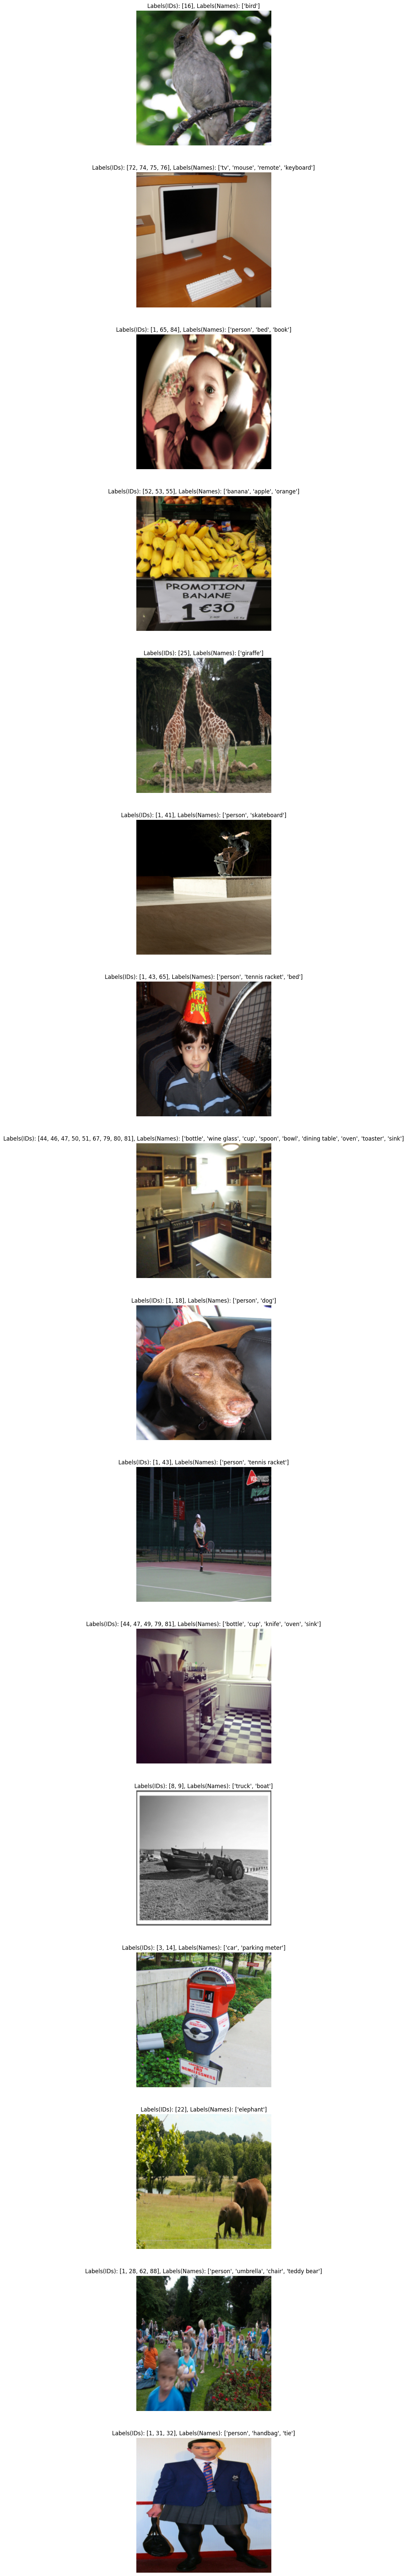

In [35]:
# Function to get category ids from multi-hot vector
def multi_hot_to_category_ids(multi_hot_vector):
    # Get hot indexes
    nonzero_indexes = torch.nonzero(multi_hot_vector).flatten().tolist()
    # Add 1 to indexes to get ids
    ids = list(np.array(nonzero_indexes) + 1)
    return ids

# Function to get category names from a ids list
def ids_to_category_names(ids_list):
    category_names = [categories[id] for id in ids_list]
    return category_names



# Visualize a batch of training data
for images, labels in data_loader_train:

    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

    # Convert multi-hot vectors to category IDs
    category_ids_list = [multi_hot_to_category_ids(label) for label in labels]

    # Convert  category IDs to category names for visualization
    category_names_list = [ids_to_category_names(ids_list) for ids_list in category_ids_list]

    # Plot images and labels
    plt.figure(figsize=(100, 100))
    for i in range(images.shape[0]):
        plt.subplot(images.shape[0], 1, i + 1)
        plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        plt.title(f"Labels(IDs): {category_ids_list[i]}, Labels(Names): {category_names_list[i]}")
        plt.axis('off')

    plt.show()

    # Show only the first batch
    break


### Design and Train a CNN model

### Design and Train a Deformable CNN model

###  Report and Compare The Models Performance